In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class RNNEncoder(nn.Module):
    def __init__(self, ntoken, ninput=300, drop_prob=0.5,
                 nhidden=128, nlayers=1, bidirectional=True):
        super().__init__()
        self.n_steps = 18
        self.ntoken = ntoken  # size of the dictionary
        self.ninput = ninput  # size of each embedding vector
        self.drop_prob = drop_prob  # probability of an element to be zeroed
        self.nlayers = nlayers  # Number of recurrent layers
        self.bidirectional = bidirectional
        if bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1
        # number of features in the hidden state
        self.nhidden = nhidden // self.num_directions

        self.encoder = nn.Embedding(self.ntoken, self.ninput)
        self.drop = nn.Dropout(self.drop_prob)

        # dropout: If non-zero, introduces a dropout layer on
        # the outputs of each RNN layer except the last layer
        self.rnn = nn.LSTM(self.ninput, self.nhidden,
                           self.nlayers, batch_first=True,
                           dropout=self.drop_prob,
                           bidirectional=self.bidirectional)


    def forward(self, captions, cap_lens):
        # input: torch.LongTensor of size batch x n_steps
        # --> emb: batch x n_steps x ninput
        emb = self.drop(self.encoder(captions))
        #
        # Returns: a PackedSequence object
        cap_lens = cap_lens.data.tolist()
        emb = pack_padded_sequence(emb, cap_lens, batch_first=True)
        # #hidden and memory (num_layers * num_directions, batch, hidden_size):
        # tensor containing the initial hidden state for each element in batch.
        # #output (batch, seq_len, hidden_size * num_directions)
        # #or a PackedSequence object:
        # tensor containing output features (h_t) from the last layer of RNN
        output, hidden = self.rnn(emb)
        # PackedSequence object
        # --> (batch, seq_len, hidden_size * num_directions)
        output = pad_packed_sequence(output, batch_first=True)[0]
        words_emb = output.transpose(1, 2)
        #print('word',words_emb.shape)
        # output = self.drop(output)
        # --> batch x hidden_size*num_directions x seq_len
        # --> batch x num_directions*hidden_size
        sent_emb = hidden[0].transpose(0, 1).contiguous()
        sent_emb = sent_emb.view(-1, self.nhidden * self.num_directions)
        return sent_emb, words_emb

    @staticmethod
    def load(weights_path: str, ntoken: int) -> 'RNNEncoder':
        text_encoder = RNNEncoder(ntoken, nhidden=256)
        state_dict = torch.load(weights_path, map_location=lambda storage, loc: storage)
        text_encoder.load_state_dict(state_dict)
        return text_encoder


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

def conv1x1(in_planes, out_planes):
    """1x1 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1,
                   padding=0, bias=False)

class GlobalAttentionGeneral(nn.Module):
    def __init__(self, idf, cdf):
        super().__init__()
        self.conv_context = conv1x1(cdf, idf)
        self.sm = nn.Softmax(dim=1)
        self.mask = None

    def applyMask(self, mask):
        self.mask = mask  # batch x sourceL

    def forward(self, input, context):
        """
        input: batch x idf x ih x iw (queryL=ihxiw)
        context: batch x cdf x sourceL
        """
        ih, iw = input.size(2), input.size(3)
        queryL = ih * iw
        batch_size, sourceL = context.size(0), context.size(2)

        # --> batch x queryL x idf
        target = input.view(batch_size, -1, queryL)
        targetT = torch.transpose(target, 1, 2).contiguous()
        
        # batch x cdf x sourceL --> batch x cdf x sourceL x 1
        sourceT = context.unsqueeze(3)
        # --> batch x idf x sourceL
        sourceT = self.conv_context(sourceT).squeeze(3)

        # Get attention
        attn = torch.bmm(targetT, sourceT)  # batch x queryL x sourceL
        attn = attn.view(batch_size * queryL, sourceL)
        
        if self.mask is not None:
            mask = self.mask.repeat(queryL, 1)
            attn.data.masked_fill_(mask.data, -float('inf'))
        
        attn = self.sm(attn)
        attn = attn.view(batch_size, queryL, sourceL)
        attn = torch.transpose(attn, 1, 2).contiguous()

        # Apply attention
        weightedContext = torch.bmm(sourceT, attn)
        weightedContext = weightedContext.view(batch_size, -1, ih, iw)
        attn = attn.view(batch_size, -1, ih, iw)

        return weightedContext, attn

class AffineBlock(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int):
        super().__init__()
        self.gamma_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, output_dim)
        )
        self.beta_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, output_dim)
        )
        self._initialize_weights()

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_normal_(module.weight)
                nn.init.zeros_(module.bias)

    def forward(self, x: Tensor, sentence_embed: Tensor) -> Tensor:
        scale_param = self.gamma_mlp(sentence_embed).unsqueeze(-1).unsqueeze(-1)
        shift_param = self.beta_mlp(sentence_embed).unsqueeze(-1).unsqueeze(-1)
        return scale_param * x + shift_param

class ResidualBlockG(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, text_dim: int = 256):
        super().__init__()
        hidden_dim = text_dim // 2
        
        self.affine1 = AffineBlock(text_dim, hidden_dim, in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        
        self.affine2 = AffineBlock(text_dim, hidden_dim, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        
        self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x: Tensor, sentence_embed: Tensor) -> Tensor:
        residual = self.skip(x)
        x = F.leaky_relu(self.affine1(x, sentence_embed), 0.2)
        x = self.conv1(x)
        x = F.leaky_relu(self.affine2(x, sentence_embed), 0.2)
        x = self.conv2(x)
        return residual + self.gamma * x


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

class Generator(nn.Module):
    def __init__(self, n_channels: int = 32, latent_dim: int = 100):
        super().__init__()
        self.n_channels = n_channels
        
        # Initial projection (4x4 spatial size)
        self.linear_in = nn.Linear(latent_dim, 8 * n_channels * 4 * 4)
        
        # Residual blocks with progressive upsampling
        self.res_blocks = nn.ModuleList([
            ResidualBlockG(8 * n_channels, 8 * n_channels),
            ResidualBlockG(8 * n_channels, 4 * n_channels),
            ResidualBlockG(4 * n_channels, 2 * n_channels),
            ResidualBlockG(2 * n_channels, n_channels),
        ])
        
        # Attention mechanism at 64x64 resolution
        self.att = GlobalAttentionGeneral(n_channels, 256)
        self.att_conv = nn.Conv2d(2 * n_channels, n_channels, kernel_size=1)
        
        # Final upsampling to 256x256
        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),  # 64->128
            nn.Conv2d(n_channels, n_channels//2, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_channels//2),
            nn.LeakyReLU(0.2, True),
            
            nn.Upsample(scale_factor=2, mode='nearest'),  # 128->256
            nn.Conv2d(n_channels//2, n_channels//4, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_channels//4),
            nn.LeakyReLU(0.2, True),
        )
        
        # Output layers
        self.conv_out = nn.Sequential(
            nn.Conv2d(n_channels//4, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, noise: Tensor, sentence_embed: Tensor, word_embed: Tensor) -> Tensor:
        # Initial projection
        x = self.linear_in(noise).view(-1, 8 * self.n_channels, 4, 4)
        
        # Process through residual blocks with 2x upsampling each
        for block in self.res_blocks:
            x = block(x, sentence_embed)
            x = F.interpolate(x, scale_factor=2, mode='nearest')  # 4->8->16->32->64
        
        # Apply attention at 64x64 resolution
        attn_out, _ = self.att(x, word_embed)
        x = torch.cat([x, attn_out], dim=1)
        x = self.att_conv(x)
        
        # Final upsampling to 256x256
        x = self.upsample(x)
        return self.conv_out(x)
        
     


In [5]:
import torch
import torchinfo

gen = Generator(n_channels=32, latent_dim=100)

noise = torch.rand((24, 100))
sent = torch.rand((24, 256))
word = torch.rand((24, 256, 18))

torchinfo.summary(gen, input_data=(noise, sent, word))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [24, 3, 256, 256]         --
├─Linear: 1-1                            [24, 4096]                413,696
├─ModuleList: 1-2                        --                        --
│    └─ResidualBlockG: 2-1               [24, 256, 4, 4]           1
│    │    └─Identity: 3-1                [24, 256, 4, 4]           --
│    │    └─AffineBlock: 3-2             [24, 256, 4, 4]           131,840
│    │    └─Conv2d: 3-3                  [24, 256, 4, 4]           590,080
│    │    └─AffineBlock: 3-4             [24, 256, 4, 4]           131,840
│    │    └─Conv2d: 3-5                  [24, 256, 4, 4]           590,080
│    └─ResidualBlockG: 2-2               [24, 128, 8, 8]           1
│    │    └─Conv2d: 3-6                  [24, 128, 8, 8]           32,896
│    │    └─AffineBlock: 3-7             [24, 256, 8, 8]           131,840
│    │    └─Conv2d: 3-8                  [24, 128, 8,

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

class ResidualBlockD(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        
        # Main convolution path
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Shortcut path (channel and spatial adjustment)
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False) 
            if in_channels != out_channels else nn.Identity(),
            nn.AvgPool2d(2)
        )

        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x: Tensor) -> Tensor:
        return self.shortcut(x) + self.gamma * self.conv(x)

class Discriminator(nn.Module):
    def __init__(self, n_c: int = 32, sentence_embed_dim: int = 256):
        super().__init__()
        
        # Image processing pathway
        self.img_encoder = nn.Sequential(
            # Initial convolution (no residual)
            nn.Conv2d(3, n_c, kernel_size=3, stride=1, padding=1),
            
            # Residual downsampling blocks
            ResidualBlockD(n_c * 1, n_c * 2),  # 256x256 -> 128x128
            ResidualBlockD(n_c * 2, n_c * 4),  # 128x128 -> 64x64
            ResidualBlockD(n_c * 4, n_c * 8),  # 64x64 -> 32x32
            ResidualBlockD(n_c * 8, n_c * 16), # 32x32 -> 16x16
            
            # Final downsampling
            nn.Conv2d(n_c*16, n_c*16, 4, 2, 1),  # 16x16 -> 8x8
            nn.Conv2d(n_c*16, n_c*16, 4, 2, 1)    # 8x8 -> 4x4
        )

        # Text-image fusion
        self.judge_net = nn.Sequential(
            nn.Conv2d(n_c*16 + sentence_embed_dim, n_c*2, 3, 1, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(n_c*2, 1, 4, 1, 0)  # Final 1x1 output
        )

    def build_embeds(self, image: Tensor) -> Tensor:
        """Extract image features (same as original)"""
        return self.img_encoder(image)

    def get_logits(self, image_embed: Tensor, sentence_embed: Tensor) -> Tensor:
        """Fuse image and text features (same interface)"""
        # Expand text to spatial dimensions
        sentence_embed = sentence_embed.view(-1, 256, 1, 1).expand(-1, -1, 4, 4)
        
        # Concatenate and classify
        combined = torch.cat((image_embed, sentence_embed), dim=1)
        return self.judge_net(combined)

In [7]:
import os
import pickle
from typing import Dict, List, Optional, Tuple

import numpy as np
import numpy.random as random
import pandas as pd
import torchvision.transforms as transforms
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from torchvision.transforms import Compose


class DFGANDataset(Dataset):
    def __init__(self, data_dir: str, split: str = "train", transform: Optional[Compose] = None):
        self.split = split
        self.data_dir = data_dir

        self.split_dir = os.path.join(data_dir, split)
        self.captions_path = os.path.join(self.data_dir, "captions.pickle")
        self.filenames_path = os.path.join(self.split_dir, "filenames.pickle")

        self.transform = transform

        self.embeddings_num = 10

        self.normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        self.images_dir = os.path.join(self.data_dir, "CUB_200_2011/CUB_200_2011/images")
        self.bbox_path = os.path.join(self.data_dir, "CUB_200_2011/CUB_200_2011/bounding_boxes.txt")
        self.images_path = os.path.join(self.data_dir, "CUB_200_2011/CUB_200_2011/images.txt")

        self.bbox = self._load_bbox()

        self.file_names, self.captions, self.code2word, self.word2code = self._load_text_data()

        self.n_words = len(self.code2word)
        self.num_examples = len(self.file_names)

        self._print_info()

    def _print_info(self):
       # print(f"Total filenames: {len(self.bbox)}")
        #print(f"Load captions from: {self.captions_path}")
        #print(f"Load file names from: {self.filenames_path} ({self.num_examples})")
        #print(f"Dictionary size: {self.n_words}")
        #print(f"Embeddings number: {self.embeddings_num}")
        print()

    def _load_bbox(self) -> Dict[str, List[int]]:
        df_bbox = pd.read_csv(self.bbox_path, delim_whitespace=True, header=None).astype(int)

        df_image_names = pd.read_csv(self.images_path, delim_whitespace=True, header=None)
        image_names = df_image_names[1].tolist()

        filename_bbox = dict()
        for i, file_name in enumerate(image_names):
            bbox = df_bbox.iloc[i][1:].tolist()
            filename_bbox[file_name[:-4]] = bbox

        return filename_bbox

    def _load_text_data(self) -> Tuple[List[str], List[List[int]],
                                       Dict[int, str], Dict[str, int]]:
        with open(self.captions_path, 'rb') as file:
            train_captions, test_captions, code2word, word2code = pickle.load(file)

        filenames = self._load_filenames()

        if self.split == 'train':
            return filenames, train_captions, code2word, word2code

        return filenames, test_captions, code2word, word2code

    def _load_filenames(self) -> List[str]:
        if os.path.isfile(self.filenames_path):
            with open(self.filenames_path, 'rb') as file:
                return pickle.load(file)

        raise ValueError(f"File {self.filenames_path} does not exist")

    def _get_caption(self, caption_idx: int) -> Tuple[np.ndarray, int]:
        caption = np.array(self.captions[caption_idx])
        pad_caption = np.zeros((18, 1), dtype='int64')

        if len(caption) <= 18:
            pad_caption[:len(caption), 0] = caption
            return pad_caption, len(caption)

        indices = list(np.arange(len(caption)))
        np.random.shuffle(indices)
        pad_caption[:, 0] = caption[np.sort(indices[:18])]

        return pad_caption, 18

    def _get_image(self, image_path: str, bbox: List[int]) -> Tensor:

        image = Image.open(image_path).convert('RGB')
        width, height = image.size

        r = int(np.maximum(bbox[2], bbox[3]) * 0.75)
        center_x = int((2 * bbox[0] + bbox[2]) / 2)
        center_y = int((2 * bbox[1] + bbox[3]) / 2)

        y1 = np.maximum(0, center_y - r)
        y2 = np.minimum(height, center_y + r)
        x1 = np.maximum(0, center_x - r)
        x2 = np.minimum(width, center_x + r)

        image = image.crop((x1, y1, x2, y2))
        image = self.normalize(self.transform(image))

        return image

    def _get_random_caption(self, idx: int) -> Tuple[np.ndarray, int]:
        caption_shift = random.randint(0, self.embeddings_num-1)
        caption_idx = idx * self.embeddings_num + caption_shift

        if caption_idx >= len(self.captions):
            caption_idx = len(self.captions) - 1 
            
        return self._get_caption(caption_idx)

    def __getitem__(self, idx: int) -> Tuple[Tensor, np.ndarray, int, str]:
        file_name = self.file_names[idx]
        image = self._get_image(f"{self.images_dir}/{file_name}.jpg", self.bbox[file_name])

        encoded_caption, caption_len = self._get_random_caption(idx)

        return image, encoded_caption, caption_len, file_name

    def __len__(self) -> int:
        return self.num_examples

In [8]:
from typing import List, Tuple

import torch
from torch import Tensor


def prepare_data(batch: Tuple[Tensor, Tensor, Tensor, Tuple[str]],
                 device: torch.device) -> Tuple[Tensor, Tensor, Tensor, List[str]]:
    images, captions, captions_len, file_names = batch

    sorted_cap_lens, sorted_cap_indices = torch.sort(captions_len, 0, True)
    sorted_cap_lens = sorted_cap_lens.to(device)

    sorted_images = images[sorted_cap_indices].to(device)
    sorted_captions = captions[sorted_cap_indices].squeeze().to(device)
    sorted_file_names = [file_names[i] for i in sorted_cap_indices.numpy()]

    return sorted_images, sorted_captions, sorted_cap_lens, sorted_file_names


In [9]:
import random
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader,Subset
from torchvision.transforms import transforms

#from objects.dataset import DFGANDataset


def create_loader(imsize: int, batch_size: int, data_dir: str, split: str) -> DataLoader:
    assert split in ["train", "test"], "Wrong split type, expected train or test"
    image_transform = transforms.Compose([
        transforms.Resize(int(imsize * 76 / 64)),
        transforms.RandomCrop(imsize),
        transforms.RandomHorizontalFlip()
    ])

    dataset = DFGANDataset(data_dir, split, image_transform)
    
    n_words = dataset.n_words
    
    subset_size=6000
    shuffled_indices = torch.randperm(len(dataset))[:6000].tolist()
    dataset = Subset(dataset, shuffled_indices)
    

    print(len(dataset))

    return DataLoader(dataset, batch_size=batch_size, drop_last=True,shuffle=True),n_words


def fix_seed(seed: int = 123321):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    print(f"Seed {seed} fixed")








In [10]:
import os.path
from typing import Tuple, List
import torch.nn.functional as F
import numpy as np
import torch
import torch.nn as nn
import torchvision.utils as vutils
from torch import Tensor
from torch.utils.data import DataLoader
from tqdm.auto import trange

#from discriminator.model import Discriminator
#from generator.model import Generator
#from objects.utils import prepare_data
#from text_encoder.model import RNNEncoder

class DeepFusionGAN:
    def __init__(self, n_words, encoder_weights_path: str, image_save_path: str, gen_path_save: str):
        super().__init__()
        self.image_save_path = image_save_path
        self.gen_path_save = gen_path_save

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.generator = Generator(n_channels=32, latent_dim=100).to(self.device)
        self.discriminator = Discriminator(n_c=32).to(self.device)

        self.text_encoder = RNNEncoder.load(encoder_weights_path, n_words)
        self.text_encoder.to(self.device)

        for p in self.text_encoder.parameters():
            p.requires_grad = False
        self.text_encoder.eval()

        # self.g_optim = torch.optim.Adam(self.generator.parameters(), lr=0.0001, betas=(0.0, 0.9))
        # self.d_optim = torch.optim.Adam(self.discriminator.parameters(), lr=0.0004, betas=(0.0, 0.9))
        self.g_optim = torch.optim.Adam(self.generator.parameters(), lr=0.0002,betas=(0.5, 0.99))
        self.d_optim = torch.optim.Adam(self.discriminator.parameters(), lr=0.0008, betas=(0.5, 0.99))

        
        self.relu = nn.ReLU()

    def _zero_grad(self):
        self.d_optim.zero_grad()
        self.g_optim.zero_grad()

    def _compute_gp(self, images: Tensor, sentence_embeds: Tensor) -> Tensor:
        batch_size = images.shape[0]

        images_interpolated = images.data.requires_grad_()
        sentences_interpolated = sentence_embeds.data.requires_grad_()

        embeds = self.discriminator.build_embeds(images_interpolated)
        logits = self.discriminator.get_logits(embeds, sentences_interpolated)

        grad_outputs = torch.ones_like(logits)
        grads = torch.autograd.grad(
            outputs=logits,
            inputs=(images_interpolated, sentences_interpolated),
            grad_outputs=grad_outputs,
            retain_graph=True,
            create_graph=True
        )

        grad_0 = grads[0].reshape(batch_size, -1)
        grad_1 = grads[1].reshape(batch_size, -1)

        grad = torch.cat((grad_0, grad_1), dim=1)
        grad_norm = grad.norm(2, 1)

        return grad_norm

    def fit(self, train_loader: DataLoader, num_epochs: int = 500,checkpoint_path: str = None) -> Tuple[List[float], List[float], List[float]]:
        g_losses_epoch, d_losses_epoch, d_gp_losses_epoch = [], [], []

        start_epoch = 0
        if checkpoint_path and os.path.exists(checkpoint_path):
            start_epoch = self._load_gen_weights(checkpoint_path)
            print(f"Resuming from epoch {start_epoch}")

        path="/kaggle/input/seagan_479/pytorch/default/1/gennormal_479.pth"
        start_epoch=self._load_gen_weights(path)
            
        for epoch in trange(start_epoch,num_epochs+start_epoch, desc="Train Deep Fusion GAN"):

            g_losses, d_losses, d_gp_losses = [], [], []
            for batch in train_loader:
                images, captions, captions_len, _ = prepare_data(batch, self.device)
                batch_size = images.shape[0]


                sentence_embeds, words_embs = self.text_encoder(captions, captions_len)
                sentence_embeds, words_embs = sentence_embeds.detach(), words_embs.detach()
                #sentence_embeds, word_embeds = self.text_encoder(captions, captions_len).detach()
                #print("images",images.shape)
                real_embeds = self.discriminator.build_embeds(images)
                #print("real_embeds",real_embeds.shape)
                #print("sent",sentence_embeds.shape)
                real_logits = self.discriminator.get_logits(real_embeds, sentence_embeds)
                #print("real_",real_logits.shape)
                d_loss_real = self.relu(1.0 - real_logits).mean()

                shift_embeds = real_embeds[:(batch_size - 1)]
                shift_sentence_embeds = sentence_embeds[1:batch_size]
                shift_real_image_embeds = self.discriminator.get_logits(shift_embeds, shift_sentence_embeds)

                d_loss_mismatch = self.relu(1.0 + shift_real_image_embeds).mean()

                noise = torch.randn(batch_size, 100).to(self.device)

                #print("noise:", noise.shape)
                #print("sent ",sentence_embeds.shape)
#                print("word",words_embs.shape)
                
                fake_images = self.generator(noise, sentence_embeds, words_embs)
               # print("fake",fake_images.shape)
               # if 6==6:
               #     return [],[],[]
                

                fake_embeds = self.discriminator.build_embeds(fake_images.detach())
                fake_logits = self.discriminator.get_logits(fake_embeds, sentence_embeds)

                d_loss_fake = self.relu(1.0 + fake_logits).mean()

                d_loss = d_loss_real + (d_loss_fake + d_loss_mismatch) / 2.0

                self._zero_grad()
                d_loss.backward()
                self.d_optim.step()

                d_losses.append(d_loss.item())

                grad_l2norm = self._compute_gp(images, sentence_embeds)
                d_loss_gp = 2.0 * torch.mean(grad_l2norm ** 6)

                self._zero_grad()
                d_loss_gp.backward()
                self.d_optim.step()

                d_gp_losses.append(d_loss_gp.item())

                fake_embeds = self.discriminator.build_embeds(fake_images)
                fake_logits = self.discriminator.get_logits(fake_embeds, sentence_embeds)
                g_loss = -fake_logits.mean()

                self._zero_grad()
                g_loss.backward()
                self.g_optim.step()

                g_losses.append(g_loss.item())


            g_losses_epoch.append(np.mean(g_losses))
            d_losses_epoch.append(np.mean(d_losses))
            d_gp_losses_epoch.append(np.mean(d_gp_losses))


            if epoch % 1 == 0:
             self._save_fake_image(fake_images, epoch)
             self._save_gen_weights(epoch)


            #print('g_losses_epoch', g_losses_epoch)
            #print('d_losses_epoch', d_losses_epoch)
            #print('gp_losses_epoch', d_gp_losses_epoch)



        return g_losses_epoch, d_losses_epoch, d_gp_losses_epoch

    def _save_fake_image(self, fake_images: Tensor, epoch: int):
        img_path = os.path.join(self.image_save_path, f"fake_samplenormal_epoch_{epoch}.png")
        vutils.save_image(fake_images.data, img_path, normalize=True)


    def _save_gen_weights(self, epoch: int):
        gen_path = os.path.join(self.gen_path_save, f"gennormal_{epoch}.pth")
        checkpoint = {
            'epoch': epoch,
            'generator_state_dict': self.generator.state_dict(),
            'discriminator_state_dict': self.discriminator.state_dict(),
            'g_optim_state_dict': self.g_optim.state_dict(),
            'd_optim_state_dict': self.d_optim.state_dict(),
        }
        torch.save(checkpoint, gen_path)
        print(f"Model checkpoint saved at epoch {epoch} to {gen_path}")

    def _load_gen_weights(self, checkpoint_path: str) -> int:
        checkpoint = torch.load(checkpoint_path)
        self.generator.load_state_dict(checkpoint['generator_state_dict'])
        self.discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        self.g_optim.load_state_dict(checkpoint['g_optim_state_dict'])
        self.d_optim.load_state_dict(checkpoint['d_optim_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"Checkpoint loaded from {checkpoint_path} - Starting from epoch {start_epoch}")
        return start_epoch


In [11]:
import os
from typing import List, Tuple

#from model import DeepFusionGAN
#from utils import create_loader, fix_seed
def train() -> Tuple[List[float], List[float], List[float]]:
    fix_seed()

    data_path = "/kaggle/input/sea-attention-gan1/cv_seattention/data"
    encoder_weights_path = "/kaggle/input/sea-attention-gan1/cv_seattention/text_encoder_weights/text_encoder200.pth"
    image_save_path = "/kaggle/working/gen_images"
    gen_path_save = "/kaggle/working/gen_weights"

    os.makedirs(image_save_path, exist_ok=True)
    os.makedirs(gen_path_save, exist_ok=True)

    train_loader,n_words= create_loader(256, 32, data_path, "train")
    model = DeepFusionGAN(n_words=n_words,
                          encoder_weights_path=encoder_weights_path,
                          image_save_path=image_save_path,
                          gen_path_save=gen_path_save)

    checkpoint_path = None
    checkpoints = sorted(
        [f for f in os.listdir(gen_path_save) if f.startswith("gennormal_") and f.endswith(".pth")],
        key=lambda x: int(x.split('_')[-1].split('.')[0])  # Extract the epoch number from the filename
    )

    if checkpoints:
        latest_checkpoint = checkpoints[-1]  # Get the latest one
        checkpoint_path = os.path.join(gen_path_save, latest_checkpoint)
        print(f"Resuming from checkpoint: {checkpoint_path}")

    num_epochs=20
    #print(len(train_loader))
    #i=0
    #for batch in train_loader:
    #    images, captions, captions_len, _ = prepare_data(batch,device)
    #    batch_size = images.shape[0]
    #    i=i+batch_size
    #print(i)

    #if 5==5:
    #    return [],[],[]
    return model.fit(train_loader,num_epochs)


#if __name__ == '__main__':
 #   train()


In [12]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [ ]:
import os
import sys
import csv

current_cwd = os.getcwd()
src_path = '/'.join(current_cwd.split('/')[:-1])
sys.path.append(src_path)
#from train import train
#from utils import plot_losses

g_losses_epoch, d_losses_epoch, d_gp_losses_epoch = train()

path = "/kaggle/working/loss"

os.makedirs(path, exist_ok=True)

filenames = [f'{path}/loss1.csv', f'{path}/loss2.csv', f'{path}/loss3.csv']

loss_values = [g_losses_epoch, d_losses_epoch, d_gp_losses_epoch]

for i in range(len(loss_values)):
    filename = filenames[i]
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Loss'])
        for loss in loss_values[i]:  
            writer.writerow([loss])



In [ ]:
import os
import sys
import torch
import time
import numpy as np
import torchvision.utils as vutils
from torch import Tensor

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure correct path handling
current_cwd = os.getcwd()
src_path = '/'.join(current_cwd.split('/')[:-1])
sys.path.append(src_path)

# Initialize generator
generator = Generator(n_channels=32, latent_dim=100).to(device)

# Load generator checkpoint
checkpoint_path = r"/kaggle/input/seagan_379/pytorch/default/1/gennormal_379.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
generator.load_state_dict(checkpoint["generator_state_dict"])
generator.eval()

# Create data loader
train_loader, n_words = create_loader(256, 24, r"/kaggle/input/sea-attention-gan1/cv_seattention/data", "test")

# Load text encoder
text_encoder = RNNEncoder.load(r"/kaggle/input/sea-attention-gan1/cv_seattention/text_encoder_weights/text_encoder200.pth", n_words)
text_encoder.to(device)
text_encoder.eval()

# Create output directory
output_path = r"/kaggle/working"
os.makedirs(output_path, exist_ok=True)

def save_image_grid(images: Tensor, filename: str, nrow: int = 8, normalize: bool = True):
    """Save a grid of images using torchvision.utils.save_image"""
    # Ensure the images are on CPU
    images = images.cpu()
    
    # Create save path
    save_path = os.path.join(output_path, filename)
    
    # Save the grid
    vutils.save_image(
        images,
        save_path,
        nrow=nrow,
        normalize=normalize,
        padding=2,
        scale_each=True
    )

def generate_multiple_images(word_caption: str, base_name: str, num_images: int = 16):
    """
    Generates multiple images from a single caption and saves them in a grid
    
    Args:
        word_caption: Text caption to generate images from
        base_name: Base name for saving the output file
        num_images: Number of different images to generate (default: 16)
    """
    dataset = train_loader.dataset.dataset
    codes = [dataset.word2code[w] for w in word_caption.lower().split()]
    
    # Prepare caption tensor
    caption = np.array(codes)
    pad_caption = np.zeros((18, 1), dtype='int64')
    
    if len(caption) <= 18:
        pad_caption[:len(caption), 0] = caption
        len_ = len(caption)
    else:
        indices = list(np.arange(len(caption)))
        np.random.shuffle(indices)
        pad_caption[:, 0] = caption[np.sort(indices[:18])]
        len_ = 18
    
    # Create text tensors - we'll process one at a time to avoid dimension issues
    caption_tensor = torch.tensor(pad_caption).reshape(1, -1).to(device)
    length_tensor = torch.tensor([len_]).to(device)
    
    # Generate all images
    generated_images = []
    for _ in range(num_images):
        # Encode text
        embed, word = text_encoder(caption_tensor, length_tensor)
        
        # Generate image with different noise each time
        noise = torch.randn(1, 100).to(device)
        with torch.no_grad():
            img = generator(noise, embed, word)
            generated_images.append(img)
    
    # Combine all generated images into a single tensor
    generated_images = torch.cat(generated_images, dim=0)
    
    # Save the grid of images
    grid_filename = f"grid_{base_name}.png"
    save_image_grid(
        generated_images,
        grid_filename,
        nrow=int(num_images**0.5)
    )
    
    print(f"Saved generated images grid to: {os.path.join(output_path, grid_filename)}")

# Example usage
if __name__ == "__main__":
    start_time = time.time()
    
    caption = "red bird with white belly and black beak"
    generate_multiple_images(
        word_caption=caption,
        base_name="yelow_white_bird",
        num_images=16  # Will create 4x4 grid
    )
    
    print(f"Time taken: {time.time() - start_time:.2f} seconds")

### Test Data

In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy import linalg
from scipy.linalg import sqrtm
from scipy.stats import entropy
from torch.nn.functional import adaptive_avg_pool2d
from tqdm.auto import tqdm

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def generate_images(generator: Generator, sentence_embeds: Tensor,word,
                    device: torch.device) -> Tensor:
    batch_size = sentence_embeds.shape[0]
    noise = torch.randn(batch_size, 100).to(device)
    return generator(noise, sentence_embeds,word)

class InceptionV3(nn.Module):
    def __init__(self):
        super().__init__()
        self.device = f'cuda:{0}' if torch.cuda.is_available() else 'cpu'
        self.model = torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True).to(self.device)
        print(self.model.fc)
        self.linear = self.model.fc
        self.model.fc, self.model.dropout = [nn.Sequential()] * 2
      
    @torch.no_grad()
    def get_last_layer(self, x):
        x = F.interpolate(x, size=300, mode='bilinear', align_corners=False, recompute_scale_factor=False)
        return self.model(x)

classifier = InceptionV3().to(device)
classifier = classifier.eval()

def calculate_fid(repr1, repr2):
    mu_r, mu_g = np.mean(repr1, axis=0), np.mean(repr2, axis=0)
    sigma_r, sigma_g = np.cov(repr1, rowvar=False), np.cov(repr2, rowvar=False)
    
    diff = mu_r - mu_g
    diff_square_norm = diff.dot(diff)
    
    product = sigma_r.dot(sigma_g)
    sqrt_product, _ = sqrtm(product, disp=False)
    

    if not np.isfinite(sqrt_product).all():
        eye_matrix = np.eye(sigma_r.shape[0]) * 1e-8
        sqrt_product = linalg.sqrtm((sigma_r + eye_matrix).dot(sigma_g + eye_matrix))

    if np.iscomplexobj(sqrt_product):
        sqrt_product = sqrt_product.real

    fid = diff_square_norm + np.trace(sigma_r + sigma_g - 2 * sqrt_product)
    
    return fid


def build_representations():
    real_reprs = np.zeros((len(test_loader) * batch_size, 2048))
    fake_reprs = np.zeros((len(test_loader) * batch_size, 2048))

    
    for i, batch in enumerate(tqdm(test_loader, desc="Build representations")):
        images, captions, captions_len, file_names = prepare_data(batch, device)
        sent_emb, word = text_encoder(captions, captions_len)
        sent_emb = sent_emb.detach()
        fake_images = generate_images(generator, sent_emb,word, device)

        clf_out_real = classifier.get_last_layer(images)
        clf_out_fake = classifier.get_last_layer(fake_images)

        real_reprs[i * batch_size: (i + 1) * batch_size] = clf_out_real.cpu().numpy()
        fake_reprs[i * batch_size: (i + 1) * batch_size] = clf_out_fake.cpu().numpy()
            
    return real_reprs, fake_reprs


def inception_score(reprs, batch_size):
    def get_pred(x):
        x = classifier.linear(torch.tensor(x, dtype=torch.float))
        return F.softmax(x).data.cpu().numpy()


    preds = np.zeros((reprs.shape[0], 1000))

    splits = 0
    for i in range(0, len(preds), batch_size):
        aaai = reprs[i:i + batch_size]
        aai = torch.tensor(aaai)
        aai = aai.to(device)
        z = get_pred(aai)
        preds[i:i + batch_size] = z
        splits += 1
    
    split_scores = []

    for k in range(splits):
        part = preds[k * batch_size: (k+1) * batch_size, :]
        py = np.mean(part, axis=0)
        
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
            
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Linear(in_features=2048, out_features=1000, bias=True)


In [19]:
model_path=["/kaggle/input/seagan_49/pytorch/default/1/gennormal_49.pth",
           "/kaggle/input/seagan_99/pytorch/default/1/gennormal_99.pth",
           "/kaggle/input/seagan_149/pytorch/default/1/gennormal_149.pth",
           "/kaggle/input/seagan_199/pytorch/default/1/gennormal_199.pth",
           "/kaggle/input/seagan_249/pytorch/default/1/gennormal_249.pth",
           "/kaggle/input/seagan_299/pytorch/default/1/gennormal_299.pth",
           "/kaggle/input/seagan_350/pytorch/default/1/gennormal_350.pth",
           "/kaggle/input/seagan_399/pytorch/default/1/gennormal_399.pth",
           "/kaggle/input/seagan_360/pytorch/default/1/gennormal_460.pth",
           "/kaggle/input/seagan_499/pytorch/default/1/gennormal_499.pth" ]

fid_test=[]
inception_test=[]
for i in range(10):
    batch_size = 32
    test_loader, n_words = create_loader(256, batch_size, "/kaggle/input/sea-attention-gan1/cv_seattention/data", "test")

    checkpoint = torch.load(model_path[i], map_location=device)

    generator = Generator(n_channels=32, latent_dim=100).to(device)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    generator.eval()

    text_encoder = RNNEncoder.load("/kaggle/input/sea-attention-gan1/cv_seattention/text_encoder_weights/text_encoder200.pth", n_words)
    text_encoder.to(device)

    for p in text_encoder.parameters():
        p.requires_grad = False
    text_encoder = text_encoder.eval()

    real_values, fake_values = build_representations()
    real_values = torch.tensor(real_values)
    fake_values = torch.tensor(fake_values)

    fid_value = calculate_fid(real_values.numpy(), fake_values.numpy())
    fid_test.append(fid_value)
    print(f"FID value = {fid_value}")


    a,b = inception_score(fake_values, batch_size)
    inception_test.append(a)
    print('inception score mean: ',a)
    print('inception score std: ',b)


2933


Build representations:   0%|          | 0/91 [00:00<?, ?it/s]

FID value = 238.65533367623294
inception score mean:  3.101332777577382
inception score std:  0.3259751282801736

2933


Build representations:   0%|          | 0/91 [00:00<?, ?it/s]

FID value = 234.6789936578817
inception score mean:  3.5348597509169926
inception score std:  0.3699208026649979

2933


Build representations:   0%|          | 0/91 [00:00<?, ?it/s]

FID value = 207.765198018991
inception score mean:  4.3050277785852025
inception score std:  0.40731560328392735

2933


Build representations:   0%|          | 0/91 [00:00<?, ?it/s]

FID value = 206.3760463636976
inception score mean:  3.8590585991231956
inception score std:  0.38370402962249206

2933


Build representations:   0%|          | 0/91 [00:00<?, ?it/s]

FID value = 180.56736417723857
inception score mean:  4.375464148279356
inception score std:  0.44043150717757507

2933


Build representations:   0%|          | 0/91 [00:00<?, ?it/s]

FID value = 172.21383511081666
inception score mean:  4.402163436464314
inception score std:  0.5124797928285968

2933


Build representations:   0%|          | 0/91 [00:00<?, ?it/s]

FID value = 170.6698478020421
inception score mean:  4.897913669967756
inception score std:  0.5682481218881025

2933


Build representations:   0%|          | 0/91 [00:00<?, ?it/s]

FID value = 157.61166460359553
inception score mean:  4.573826642566516
inception score std:  0.4525234629671817

2933


Build representations:   0%|          | 0/91 [00:00<?, ?it/s]

FID value = 158.51134397783883
inception score mean:  4.572810571636573
inception score std:  0.5735019684376201

2933


Build representations:   0%|          | 0/91 [00:00<?, ?it/s]

FID value = 139.71830456297522
inception score mean:  4.7751866008746005
inception score std:  0.5978062723976851


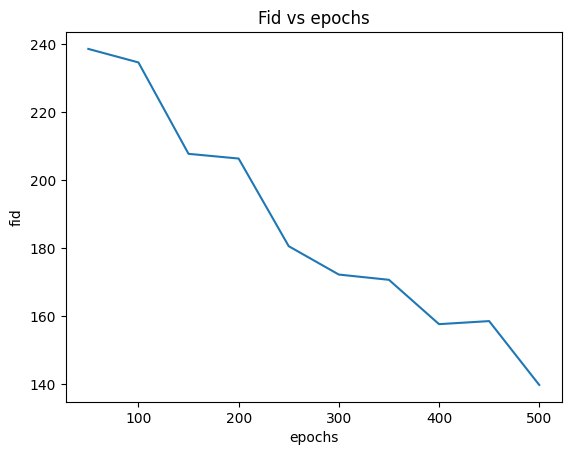

In [22]:
x=[50,100,150,200,250,300,350,400,450,500]
plt.plot(x,fid_test)
plt.title("Fid vs epochs")
plt.xlabel("epochs")
plt.ylabel("fid")
plt.show()


[3.101332777577382, 3.5348597509169926, 4.3050277785852025, 3.8590585991231956, 4.375464148279356, 4.402163436464314, 4.897913669967756, 4.573826642566516, 4.572810571636573, 4.7751866008746005]


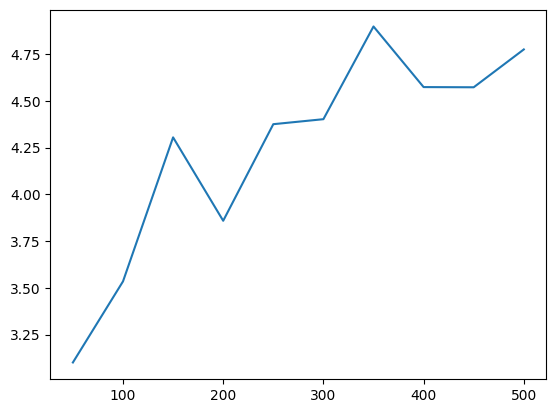

In [23]:
x=[50,100,150,200,250,300,350,400,450,500]
print(inception_test)
plt.plot(x,inception_test)
plt.show()